In [ ]:
import sys, os, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

In [2]:
# from src.generator import data_generator, clip_generator, label_generator
from src.data import data_generator
from src.util import characters, id_from_char, char_from_id
from src.export import display_progress

from pymongo import MongoClient
from tensorflow import keras

import numpy as np
import pickle

In [3]:
for character in characters:
    print(character)

CAPTAIN_FALCON
DONKEY_KONG
FOX
GAME_AND_WATCH
KIRBY
BOWSER
LINK
LUIGI
MARIO
MARTH
MEWTWO
NESS
PEACH
PIKACHU
ICE_CLIMBERS
JIGGLYPUFF
SAMUS
YOSHI
ZELDA
SHEIK
FALCO
YOUNG_LINK
DR_MARIO
ROY
PICHU
GANONDORF


# The Model

Source code for model creation is in src/models.py

In [4]:
from tensorflow.keras.optimizers import Adam, Nadam
adam = Adam(learning_rate=0.0001)
nadam = Nadam(learning_rate=0.0001)

In [5]:
# # to make a new model
# from src.models import custom_mk2 as Model
# model = Model()

# to load the saved model
model = keras.models.load_model('../models/custom_mk2')

# from src.models import focal_loss, top_8_accuracy
# model.compile(loss=focal_loss,
#               optimizer=nadam,
#               metrics=['accuracy', top_8_accuracy])

In [6]:
model.summary()

Model: "custom_mk2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, None, 150)         58650     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 150)         0         
_________________________________________________________________
conv2.1 (Conv1D)             (None, None, 128)         288128    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv3.1 (Conv1D)             (None, None, 128)         245888    
_________________________________________________________________
conv3.2 (Conv1D)             (None, None, 128)         245888    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 128)         0

# Testing

In [7]:
data_test = data_generator(input_directory='../data/test',
                           batch_size = 25,
                           num_batches = 50,
                           shuffle=True)

In [8]:
score = model.evaluate(data_test, verbose=1)

print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 categorical accuracy: {round(score[2]*100)}%') 

50/50 [==============================] - 4s 73ms/step - loss: 0.0331 - accuracy: 0.9448 - top 8 accuracy: 0.9784

Test score: 0.033
Test accuracy: 94%
Test test top 8 categorical accuracy: 98%


# Confusion Matrix

In [9]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [10]:
def get_conf_matrix(labels_as_id, predictions_as_id):
    conf_matrix = np.zeros((27,27))
    for i_real, i_pred in zip(labels_as_id, predictions_as_id):
        conf_matrix[i_real, i_pred] += 1
    return conf_matrix

In [11]:
num_batches = 100
data_test = data_generator(input_directory='../data/test',
                           batch_size = 100,
                           num_batches = num_batches,
                           shuffle=True,
                           onehot=False)

In [12]:
recalls = {k:0 for k in range(1,27)}
precisions = {k:0 for k in range(1,27)}

batch_preds = []
batch_labels = []
i = 0

for xi, yi in data_test:
    batch_preds.append(np.argmax(model.predict(xi), axis=1))
    batch_labels.append(yi)
    
    i+=1
    display_progress(i, num_batches)
display_progress(num_batches, num_batches)
    
pred = np.concatenate(batch_preds)
labels = np.concatenate(batch_labels)

conf_matrix = get_conf_matrix(labels, pred)
conf_df = pd.DataFrame(conf_matrix[1:,1:], index=characters, columns=characters)

[####################] 100 of 100 - 100.0% 

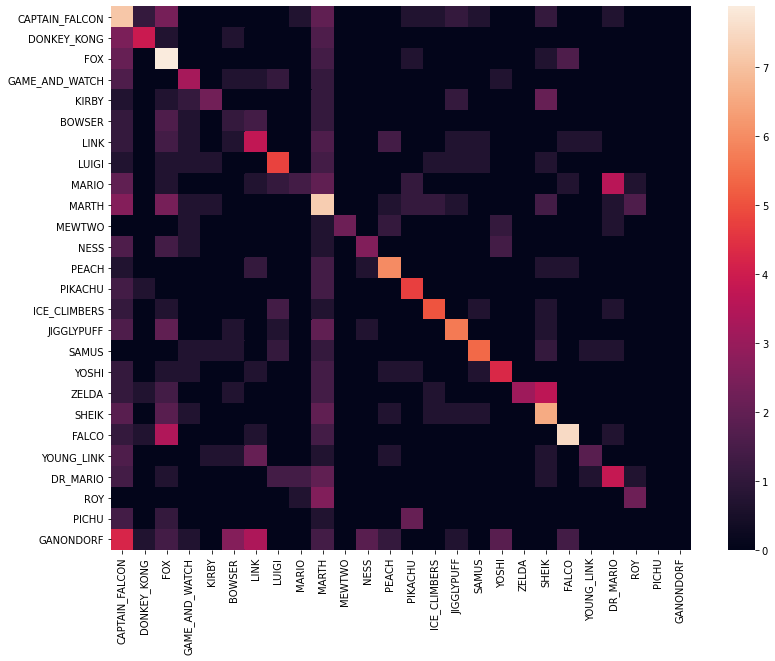

In [13]:
# sn.heatmap(conf_df, annot=False, mask=conf_df <= 0, cmap='viridis')
fig, ax = plt.subplots(figsize=(13,10))
sn.heatmap(np.log(1 + conf_df), annot=False, ax=ax, square=False)
fig.savefig('../images/confusion_matrix.png')

# Training

In [ ]:
# skip first 100k clips and save them as test data
data_train = data_generator(input_directory='../data/test',
                            batch_size = 25,
                            repeat=True)

In [ ]:
# custom_mk2
model.fit(data_train,
          epochs=5,
          steps_per_epoch=500,
          verbose=1)

score = model.evaluate(data_train, steps=50, verbose=0)
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 accuracy: {round(score[2]*100)}%')

In [ ]:
model.save('../models/custom_mk2')